<a href="https://colab.research.google.com/github/Gorzkun/Demon-Slayer-Script-Analysis/blob/main/Demon_Slayer_Script_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demon Slayer Script Analysis: Season 1

In [1]:
!rm -r Demon-Slayer-Script-Analysis/ #Erase the repository for any update

rm: cannot remove 'Demon-Slayer-Script-Analysis/': No such file or directory


In [2]:
!git clone https://github.com/Gorzkun/Demon-Slayer-Script-Analysis #Import the repository on Github

Cloning into 'Demon-Slayer-Script-Analysis'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 75 (delta 0), reused 0 (delta 0), pack-reused 72
Unpacking objects: 100% (75/75), done.


In [51]:
#Import libraries
import pandas as pd #To read data.
import re
import nltk #To analyze text.
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download ('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.casual import regex
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize.casual import regex
from nltk.classify import NaiveBayesClassifier
import matplotlib.pyplot as plt #For any visual aid.
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import plotly.express as px
from nltk.sentiment.vader import SentimentIntensityAnalyzer #For sentiment analysis.
nltk.download('vader_lexicon')
from wordcloud import WordCloud #To generate a Word Cloud.
from PIL import Image
from wordcloud import ImageColorGenerator
!pip install bar_chart_race
import bar_chart_race as bcr #To get the visual aid for interesting.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Import script
df = pd.read_csv("/content/Demon-Slayer-Script-Analysis/Script_Demon_Slayer_S1.txt", sep=";")
df['Dialog'] = df['Dialog'].astype(str)

#I know "Dialog" is misspelled (shame on me).
df.head()

,Index,Season,Episode,Episode_name,Character_name,Character_race,Gender,Dialog
0,1,1,1,Cruelty,Tanjiro,Human,Male,"How? How did this happen? Nezuko, don't die! D..."
1,2,1,1,Cruelty,Kie Kamado,Human,Female,Tanjiro? Your face is covered in soot. Come ov...
2,3,1,1,Cruelty,Tanjiro,Human,Male,"Well, I want everyone to eat their fill on New..."
3,4,1,1,Cruelty,Kie Kamado,Human,Female,Thank you.
4,5,1,1,Cruelty,Shigeru Kamado,Human,Male,Big Bro! You're going to town again today?


In [5]:
# Clean text
stop_words = set(stopwords.words('english'))
# add words that aren't in the NLTK stopwords list
new_stopwords = ['thats','weve','hes','theres','ive','im','will','can','cant','dont','youve','us'
        ,'youre','youll','theyre','whats','didnt']
new_stopwords_list = stop_words.union(new_stopwords)

# After previous text analysis, some words needed replacements in order to take part in the exploratory analysis
exception_map={
    "gonna": "going to",
    "demon hunter": "demon-hunter",
    " i'll":" i will",
    "demon slayer":"demon-slayer"}

df['Dialogue_clean'] = df['Dialog'].apply(lambda x: x.lower())
df['Dialogue_clean'] = df['Dialogue_clean'].replace(exception_map, regex=True)
df["Dialogue_clean"] = df['Dialogue_clean'].str.replace('[^\w\s]','')
df.Dialogue_clean = df.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
df.Dialogue_clean = df.Dialogue_clean.str.replace('  ', '')
df['Dialogue_clean'] = df['Dialogue_clean'].apply(nltk.word_tokenize)
df['NumberOfWords'] = df['Dialogue_clean'].str.len()
df.head()

<ipython-input-5-09f5ada19d9d>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Dialogue_clean"] = df['Dialogue_clean'].str.replace('[^\w\s]','')


,Index,Season,Episode,Episode_name,Character_name,Character_race,Gender,Dialog,Dialogue_clean,NumberOfWords
0,1,1,1,Cruelty,Tanjiro,Human,Male,"How? How did this happen? Nezuko, don't die! D...","[happen, nezuko, die, die, going, save, matter...",15
1,2,1,1,Cruelty,Kie Kamado,Human,Female,Tanjiro? Your face is covered in soot. Come ov...,"[tanjiro, face, covered, soot, come, dangerous...",9
2,3,1,1,Cruelty,Tanjiro,Human,Male,"Well, I want everyone to eat their fill on New...","[well, want, everyone, eat, fill, new, years, ...",11
3,4,1,1,Cruelty,Kie Kamado,Human,Female,Thank you.,[thank],1
4,5,1,1,Cruelty,Shigeru Kamado,Human,Male,Big Bro! You're going to town again today?,"[big, bro, going, town, today]",5


## 1.-Exploratory Analysis

In [6]:
# Set a couple of temporary Data Frames.
# First of all get the characters with more words and dialogues.
speaks_more = df.groupby('Character_name')['NumberOfWords'].agg(['sum','count'])
speaks_more = speaks_more.sort_values(by = 'sum', ascending=False)
# Get a temporary dataframe in the right format for any analysis.
df_unpivot = df.explode('Dialogue_clean')
df_unpivot = df_unpivot.drop(['Dialog','Character_race','Gender','Episode_name'], axis=1)
# Get the most common word by character
fav_last = df_unpivot.groupby(['Character_name','Dialogue_clean']).size().reset_index(name='Frequency')
fav_last['index'] = fav_last['Character_name']+fav_last['Dialogue_clean']

fav = df_unpivot.groupby('Character_name')['Dialogue_clean'].apply(
    lambda x: x.mode().iat[0]).reset_index(name='Favourite Word')
fav['index'] = fav['Character_name']+fav['Favourite Word']
fav = pd.merge(fav,fav_last,how='inner')
fav = fav.drop(['index','Dialogue_clean'], axis=1)
# Merge the two dataframes to get a nice "Profile"
final_profile = pd.merge(fav,speaks_more, on='Character_name')
final_profile = final_profile.rename(columns={'sum':'Number of Words','count':'Number of Dialogues'})
#Test the profile with Nezuko
final_profile.loc[final_profile['Character_name']=='Nezuko']

,Character_name,Favourite Word,Frequency,Number of Words,Number of Dialogues
60,Nezuko,blood,4,50,7


In [7]:
final_profile = final_profile.sort_values(by='Number of Words', ascending = False)
final_profile.head(10)

,Character_name,Favourite Word,Frequency,Number of Words,Number of Dialogues
94,Tanjiro,nezuko,142,6396,682
115,Zenitsu,going,44,2213,217
27,Inosuke,going,32,1077,175
80,Shinobu Kocho,right,18,964,82
100,Urokodaki,demons,18,735,57
71,Rui (Lower Moon 5),bond,12,707,67
93,Tamayo,demons,22,617,54
21,Giyu Tomioka,demon,10,421,32
48,Master Ubuyashiki,tanjiro,8,351,28
114,Yushiro,lady,18,305,43


In [8]:
#Since I didnt get the desired result with Inosuko and Zenitsu, lets try a different approach
#Lets try tagging the tokens
df_tagged = df
df_tagged['Dialogue_tagged']  = df_tagged['Dialog'].apply(lambda x: x.lower())
df_tagged['Dialogue_tagged']  = df_tagged['Dialogue_tagged'].apply(nltk.word_tokenize)
df_tagged['Dialogue_tagged']  = df_tagged['Dialogue_tagged'].apply(nltk.pos_tag)
#Same process as before, put the data frame in the right format
df_tagged_unpivot = df_tagged.explode('Dialogue_tagged')
df_tagged_unpivot['Top'] = df_tagged_unpivot.groupby('Character_name')['Character_name'].transform('count')
df_tagged_unpivot = df_tagged_unpivot.drop(['Index','Season','Episode','Episode_name','Character_race','Gender','Dialog','Dialogue_clean','NumberOfWords'], axis=1)
#Filter the dataframe by only nouns and adjectives
df_tagged_final = df_tagged_unpivot
df_tagged_final[['Word','Tag']] = pd.DataFrame(df_tagged_final['Dialogue_tagged'].tolist(), index=df_tagged_final.index)
df_tagged_final = df_tagged_final[df_tagged_final['Word'] != "i"]
df_tagged_final['Word'] = df_tagged_final['Word'].str.replace('[^\w\s]','')
df_tagged_final = df_tagged_final[df_tagged_final['Word'] != '']
df_tagged_final = df_tagged_final[df_tagged_final['Tag'].str.contains("NN|JJ")]

<ipython-input-8-165278f28a8f>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tagged_final['Word'] = df_tagged_final['Word'].str.replace('[^\w\s]','')
<ipython-input-8-165278f28a8f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tagged_final['Word'] = df_tagged_final['Word'].str.replace('[^\w\s]','')


In [9]:
#Same process as before
fav_last_tag = df_tagged_final.groupby(['Character_name','Word','Top']).size().reset_index(name='Frequency')
fav_last_tag['index'] = fav_last_tag['Character_name']+fav_last_tag['Word']
fav_tag = df_tagged_final.groupby('Character_name')['Word'].apply(
    lambda x: x.mode().iat[0]).reset_index(name='Favourite Word')
fav_tag['index'] = fav_tag['Character_name']+fav_tag['Favourite Word']
fav_tag = pd.merge(fav_tag,fav_last_tag,how='inner')
fav_tag = fav_tag.drop(['index','Word'], axis=1)
fav_tag = fav_tag.sort_values(by = 'Top', ascending=False)
#Lets see how different is the final profile with that filter
final_profile_tag = pd.merge(fav_tag,speaks_more, on='Character_name')
final_profile_tag = final_profile_tag.drop('Top', axis=1)
final_profile_tag = final_profile_tag.rename(columns={'sum':'Number of Words','count':'Number of Dialogues'})
#Try again with Nezuko
final_profile_tag.loc[final_profile_tag['Character_name']=='Nezuko']

,Character_name,Favourite Word,Frequency,Number of Words,Number of Dialogues
53,Nezuko,blood,4,50,7


In [10]:
final_profile_tag.head()
#its seems some "Nezukos" are have other tags besides Noun and Adjective, which is weird, but I'll take it. 

,Character_name,Favourite Word,Frequency,Number of Words,Number of Dialogues
0,Tanjiro,nezuko,114,6396,682
1,Zenitsu,tanjiro,39,2213,217
2,Inosuke,hell,18,1077,175
3,Shinobu Kocho,demon,14,964,82
4,Rui (Lower Moon 5),bond,12,707,67


In [11]:
#Let's see the most common words overall and find out what the series is all about.
lemmatized_words = df

lemmatizer = WordNetLemmatizer()

lemmatized_words['Lemmatized'] = lemmatized_words['Dialogue_clean'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])

word_evolution = lemmatized_words.explode('Lemmatized')
word_evolution = word_evolution.groupby(['Episode'])['Lemmatized'].value_counts().to_frame(name='Frequency')
word_evolution = word_evolution.pivot_table(columns='Lemmatized', values='Frequency', fill_value=0, index='Episode')
word_evolution = word_evolution.cumsum()

In [72]:
# bcr.bar_chart_race(df = word_evolution, title ='Season 1 Top Words',
#                    n_bars = 10,
#                    label_bars= True,
#                    figsize=(4,3),
#                    orientation = 'h',
#                    steps_per_period=5,
#                    filter_column_colors = True)

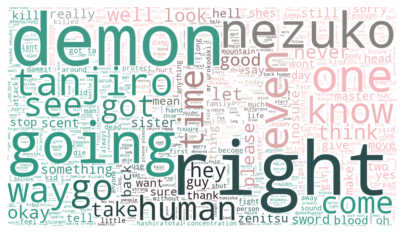

In [15]:
#Let's put all those words into a wordcloud
import numpy as np

word_cloud_list = lemmatized_words.explode('Lemmatized')
word_cloud_list = word_cloud_list['Lemmatized'].to_list()
word_cloud_list = pd.DataFrame(word_cloud_list, columns =['Words'])
word_cloud_list = word_cloud_list['Words'].str.cat(sep=' ')

mask = np.array(Image.open("/content/Demon-Slayer-Script-Analysis/mask3.png"))
wordcloud_kny = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(word_cloud_list)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_kny.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
#plt.savefig("img/us_wine.png", format="png")

plt.show()

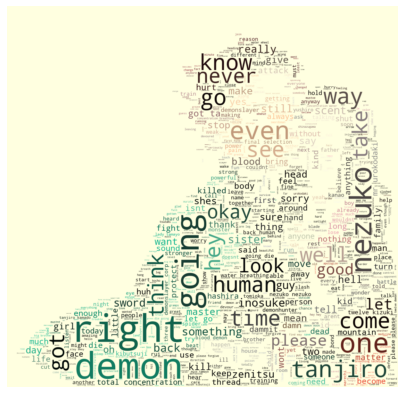

In [16]:
#Just for fun lets try another option at a wordcloud
mask_2 = np.array(Image.open("/content/Demon-Slayer-Script-Analysis/mask5.png"))
wordcloud_kny_2 = WordCloud(background_color='lightyellow',mode="RGBA", max_words=1000, mask=mask_2).generate(word_cloud_list)

# create coloring from image
image_colors_2 = ImageColorGenerator(mask_2)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_kny_2.recolor(color_func=image_colors_2), interpolation="bilinear")
plt.axis("off")

# store to file
#plt.savefig("img/us_wine.png", format="png")

plt.show()

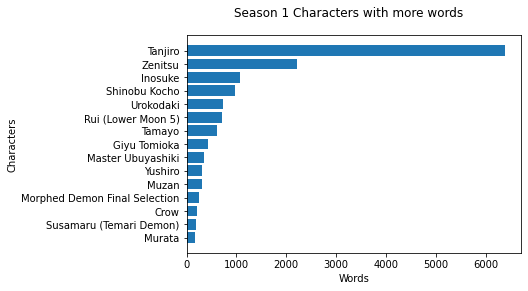

In [17]:
#Now to finalize the exploratory analysis lets find out some fun facts:

#Top 15 characters with more words
top_character_w = speaks_more.sort_values(by='sum', ascending = False).head(15)
top_character_w = top_character_w.sort_values(by='sum', ascending = True)

top_character_d = speaks_more.sort_values(by='count', ascending = False).head(15)
top_character_d = top_character_d.sort_values(by='count', ascending = True)

top_character_w_labels = top_character_w.index.to_list()
top_character_words = top_character_w['sum'].to_list()

fig, ax = plt.subplots()
fig.suptitle('Season 1 Characters with more words')

ax.barh(top_character_w_labels, top_character_words)
ax.set_ylabel('Characters')
ax.set_xlabel('Words')

plt.show()

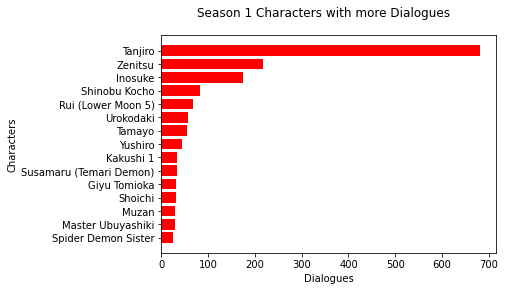

In [18]:
#Top 15 characters with more dialogues
top_character_d_labels = top_character_d.index.to_list()
top_character_dialogue = top_character_d['count'].to_list()

fig, ax = plt.subplots()
fig.suptitle('Season 1 Characters with more Dialogues')

ax.barh(top_character_d_labels, top_character_dialogue, color ='r')
ax.set_ylabel('Characters')
ax.set_xlabel('Dialogues')

plt.show()

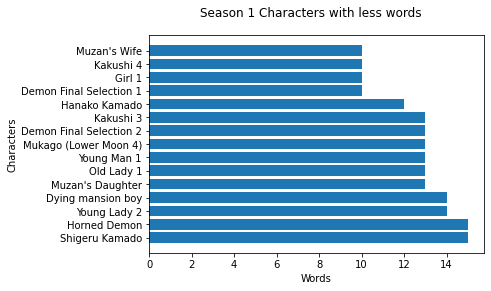

In [19]:
#Since Nezuko obviously doesnt show up, lets find out the characters with less words and dialogues, but with a small filter:

bottom_character_w = speaks_more[speaks_more['sum'] >= 10] #Characters with at least more than 10 words
bottom_character_w = bottom_character_w.sort_values(by='sum', ascending = True).head(15)
bottom_character_w = bottom_character_w.sort_values(by='sum', ascending = False)

bottom_character_d = speaks_more[speaks_more['count'] >= 5] #characters with at least more than 5 dialogues
bottom_character_d = bottom_character_d.sort_values(by='count', ascending = True).head(15)
bottom_character_d = bottom_character_d.sort_values(by='count', ascending = False)

bottom_character_w_labels = bottom_character_w.index.to_list()
bottom_character_words = bottom_character_w['sum'].to_list()

fig, ax = plt.subplots()
fig.suptitle('Season 1 Characters with less words')

ax.barh(bottom_character_w_labels, bottom_character_words)
ax.set_ylabel('Characters')
ax.set_xlabel('Words')

plt.show()

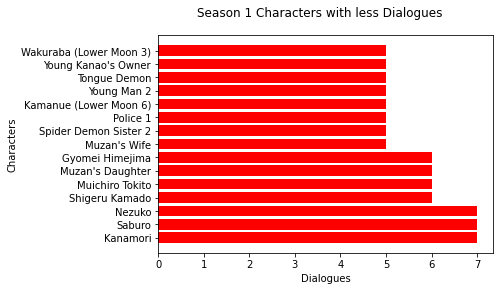

In [21]:
bottom_character_d_labels = bottom_character_d.index.to_list()
bottom_character_dialogue = bottom_character_d['count'].to_list()

fig, ax = plt.subplots()
fig.suptitle('Season 1 Characters with less Dialogues')

ax.barh(bottom_character_d_labels, bottom_character_dialogue, color ='r')
ax.set_ylabel('Characters')
ax.set_xlabel('Dialogues')

plt.show()

In [23]:
#To make it fun, lets do the same evolution in words, for the characters

race_characters = df.groupby(['Episode','Character_name'])['NumberOfWords'].agg(['sum','count']).reset_index()
race_characters = race_characters.sort_values(by = 'Episode', ascending=True)
print(race_characters.columns)

race_characters_w = race_characters.pivot_table(columns='Character_name', values='sum', fill_value=0, index='Episode')
race_characters_w = race_characters_w.cumsum()

Index(['Episode', 'Character_name', 'sum', 'count'], dtype='object')


In [24]:
bcr.bar_chart_race(df = race_characters_w, title ='Season 1 Words per Character',
                   n_bars = 10,
                   label_bars= True,
                   figsize=(4,3),
                   orientation = 'h',
                   steps_per_period=4,
                   filter_column_colors = True)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 132 missing from current font.
  font.set_text(s, 0.0,

In [32]:
#We already have the "Profile", but I wanted more insight on what each character is all about.
#So lets get the top words for the "main characters", or at least the ones who speak the most.

main_characters = final_profile.sort_values(by = 'Number of Words', ascending =False).head(14) #Just 14 + Nezuko to get a total of 15.
main_characters = main_characters['Character_name'].values.tolist()
main_characters.append('Nezuko') #Nezuko wont show up in the main characters, so I am adding her manually
print(main_characters)

['Tanjiro', 'Zenitsu', 'Inosuke', 'Shinobu Kocho', 'Urokodaki', 'Rui (Lower Moon 5)', 'Tamayo', 'Giyu Tomioka', 'Master Ubuyashiki', 'Yushiro', 'Muzan', 'Morphed Demon Final Selection', 'Crow', 'Susamaru (Temari Demon)', 'Nezuko']


In [33]:
top_words = df_tagged_final #Lets use the data frame with only nouns and adjectives
top_words['Fixed_number'] = 1
#top_words['Word'] = pd.DataFrame(lemmatized_words, columns = ['Word'])
top_words = top_words.groupby(['Character_name'])['Word'].value_counts().reset_index(name = 'Total')
top_words = top_words.sort_values(by = 'Total', ascending = False).groupby('Character_name', sort=False).head(5)
top_words = top_words.sort_values(by = 'Character_name', ascending= False)
top_words = top_words[top_words['Character_name'].isin(main_characters)]
top_words = top_words.groupby('Character_name')['Word'].apply(list).to_frame('Top Words')
top_words.head()

,Top Words
Character_name,
Crow,"[demon, southsoutheast, tanjiro, marechi, next]"
Giyu Tomioka,"[demons, way, demon, sister, family]"
Inosuke,"[hell, dammit, way, thing, hey]"
Master Ubuyashiki,"[tanjiro, demon, kibutsuji, humans, children]"
Morphed Demon Final Selection,"[fox, masks, urokodaki, brother, dammit]"


## 2.-Bigram Analysis

In [34]:
#To analyze the script in bigrams, I am going to re-do most of the work done to the original dataframe
bigrams = df

bigrams = bigrams.drop(['Dialogue_clean','NumberOfWords','Dialogue_tagged'], axis=1)

In [35]:
#New exception map and new clean tokenization
exception_map2={
    "gonna": "going to",
    " ill":" i will"}

bigrams['Dialogue_clean'] = bigrams['Dialog'].apply(lambda x: x.lower())
bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].replace(exception_map2, regex=True)
bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].str.replace('[^\w\s]','')
bigrams.Dialogue_clean = bigrams.Dialogue_clean.str.split().apply\
        (lambda x: ' '.join(item for item in x if item not in new_stopwords_list))
bigrams.Dialogue_clean = bigrams.Dialogue_clean.str.replace('  ', '')
bigrams['Bigrams'] = bigrams['Dialogue_clean'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
bigrams = bigrams.explode('Bigrams')

<ipython-input-35-d9c3803ac3db>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  bigrams['Dialogue_clean'] = bigrams['Dialogue_clean'].str.replace('[^\w\s]','')


In [36]:
#Finally lets see the result
bigrams_fav = bigrams.groupby('Bigrams').size().reset_index(name='Total')
bigrams_fav = bigrams_fav.sort_values(by = 'Total', ascending=False)
bigrams_fav.head(10)

,Bigrams,Total
2566,"(demon, slayer)",38
12879,"(total, concentration)",29
8043,"(mr, urokodaki)",27
13157,"(twelve, kizuki)",25
13602,"(water, breathing)",25
8395,"(nezuko, nezuko)",23
10984,"(slayer, corps)",23
4488,"(going, die)",22
6790,"(lets, go)",21
2567,"(demon, slayers)",21


## 3.-Gender and race equity

In [25]:
#Lets see what about the gender equity
gender_equity = df.groupby('Gender')['NumberOfWords'].agg(['sum','count'])
gender_equity['%Words'] = (gender_equity['sum'] / gender_equity['sum'].sum())*100
gender_equity['%Words'] = gender_equity['%Words'].round(2)
gender_equity['%Dialogues'] = (gender_equity['count'] / gender_equity['count'].sum())*100
gender_equity['%Dialogues'] = gender_equity['%Dialogues'].round(2)
gender_equity.head()

,sum,count,%Words,%Dialogues
Gender,,,,
Bird,218,25,1.12,1.11
Female,3399,446,17.54,19.77
Male,15460,1756,79.77,77.84
N/a,303,29,1.56,1.29


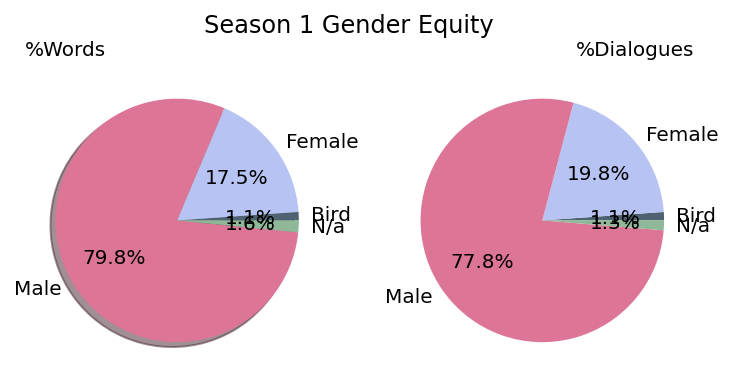

In [27]:
pie_labels_gender = gender_equity.index.to_list()
colors_pie_gender = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

fig = plt.figure(figsize=(6,3),dpi=144)
fig.suptitle('Season 1 Gender Equity')
ax = fig.add_subplot(121)
ax.pie(gender_equity['%Words'], labels=pie_labels_gender, shadow=True, autopct='%1.1f%%', colors=colors_pie_gender)
ax.set_title('%Words', fontsize=10, loc = 'left')

ax = fig.add_subplot(122)
ax.pie(gender_equity['%Dialogues'], labels=pie_labels_gender, autopct='%1.1f%%', colors=colors_pie_gender)
ax.set_title('%Dialogues', fontsize=10, loc = 'right')

plt.show()

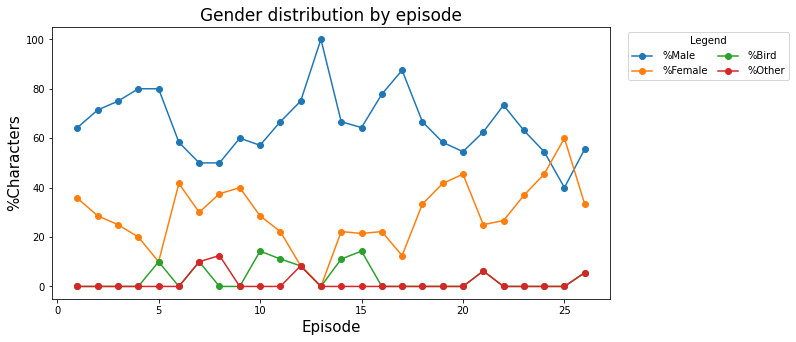

In [28]:
#This, as many other parts in the notebook, could easily be a function, but I like to sabotage myself
#Lets see the gender distribution by character appearance in each episode.
genderbycharacter = df.groupby(['Gender','Episode'])['Character_name'].nunique().reset_index(name='Total')
genderbycharacter = genderbycharacter.pivot_table(index='Episode', columns='Gender', values='Total', fill_value=0)
genderbycharacter['Total'] = genderbycharacter.sum(axis=1)
genderbycharacter['%Male'] = (genderbycharacter['Male'] / genderbycharacter['Total'])*100
genderbycharacter['%Male'] = genderbycharacter['%Male'].round(2)
genderbycharacter['%Female'] = (genderbycharacter['Female'] / genderbycharacter['Total'])*100
genderbycharacter['%Female'] = genderbycharacter['%Female'].round(2)
genderbycharacter['%Bird'] = (genderbycharacter['Bird'] / genderbycharacter['Total'])*100
genderbycharacter['%Bird'] = genderbycharacter['%Bird'].round(2)
genderbycharacter['%Other'] = (genderbycharacter['N/a'] / genderbycharacter['Total'])*100
genderbycharacter['%Other'] = genderbycharacter['%Other'].round(2)
genderbycharacter = genderbycharacter.drop(['Bird','Female','Male','N/a','Total'], axis=1)

genderbycharacter.plot(legend=True, figsize=(10,5), marker='o')
plt.legend(ncol=2,  bbox_to_anchor=[1.33, 1], handlelength=2, handletextpad=1, columnspacing=1, title='Legend')

plt.title('Gender distribution by episode', color='black', fontsize=17)              
plt.xlabel('Episode', fontsize=15)
plt.ylabel('%Characters', fontsize=15)
plt.show()

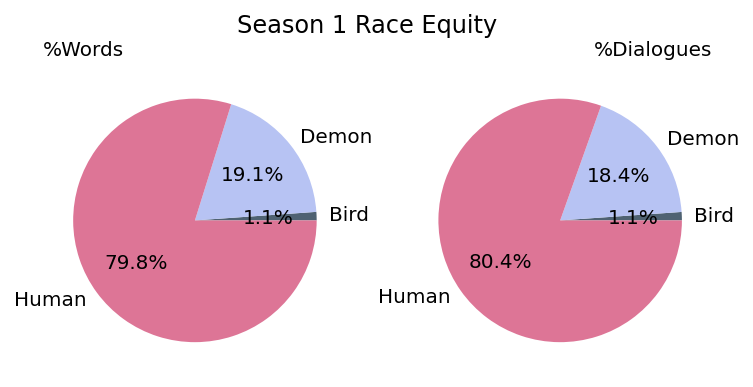

In [31]:
#Now what about race?
race_equity = df.groupby('Character_race')['NumberOfWords'].agg(['sum','count'])
race_equity['%Words'] = (race_equity['sum'] / race_equity['sum'].sum())*100
race_equity['%Words'] = race_equity['%Words'].round(2)
race_equity['%Dialogues'] = (race_equity['count'] / race_equity['count'].sum())*100
race_equity['%Dialogues'] = race_equity['%Dialogues'].round(2)

colors_pie_race = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

pie_labels = race_equity.index.to_list()

fig = plt.figure(figsize=(6,3),dpi=144)
fig.suptitle('Season 1 Race Equity')
ax = fig.add_subplot(121)
ax.pie(race_equity['%Words'], labels=pie_labels, autopct='%1.1f%%', colors=colors_pie_race)
ax.set_title('%Words', fontsize=10, loc = 'left')

ax = fig.add_subplot(122)
ax.pie(race_equity['%Dialogues'], labels=pie_labels, autopct='%1.1f%%', colors=colors_pie_race)
ax.set_title('%Dialogues', fontsize=10, loc = 'right')

plt.show()

## 4.-Sentiment analysis with NRC

In [37]:
#Lets use a new dataframe
df_nrc = df
df_nrc = df_nrc.explode('Dialogue_clean')
df_nrc = df_nrc.drop(['Dialog','Dialogue_tagged','NumberOfWords'], axis=1)
df_nrc = df_nrc.rename(columns={'Dialogue_clean':'Word'})

#And import the nrc text document
file_nrc = r'/content/Demon-Slayer-Script-Analysis/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt'
sentiment = pd.read_csv(file_nrc, delimiter='\t',header=None)
sentiment.columns = ['Word', 'Emotion', 'isPresent']
sentiment_final = sentiment[sentiment['isPresent'] == 1]

In [38]:
nrc_analysis = pd.merge(df_nrc,sentiment_final, on='Word') #A quick merge
anime_sentiment = nrc_analysis.groupby(['Emotion']).size().reset_index(name='Value')
anime_sentiment = anime_sentiment.set_index('Emotion').T
#Lets see the overall result.
anime_sentiment.head()

Emotion,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
Value,987,815,777,1187,619,1901,1473,1083,417,786


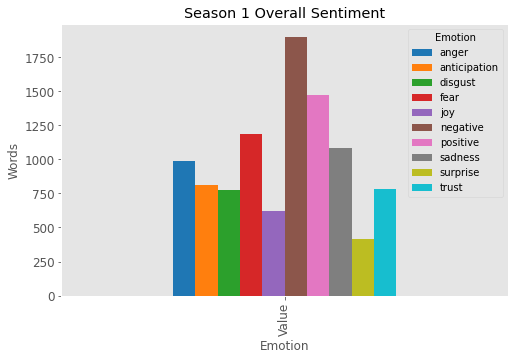

In [39]:
plt.style.use('ggplot')
axs = anime_sentiment \
    .plot(kind='bar', title="Season 1 Overall Sentiment", figsize=(8, 5), legend=True, fontsize=12)
axs.set_xlabel("Emotion", fontsize=12)
axs.set_ylabel("Words", fontsize=12)
plt.show()

In [47]:
#And to make it fun
race_nrc_sentiment = nrc_analysis.groupby(['Episode','Emotion'])['isPresent'].sum().to_frame(name='Total')
race_nrc_sentiment = race_nrc_sentiment.pivot_table(columns='Emotion', values='Total', fill_value=0, index='Episode')
race_nrc_sentiment = race_nrc_sentiment.cumsum()

bcr.bar_chart_race(df = race_nrc_sentiment, title ='Season 1 - Emotion analysis',
                   n_bars = 10,
                   label_bars= True,
                   figsize=(4,3),
                   orientation = 'v',
                   fixed_order = True,
                   steps_per_period=4,
                   filter_column_colors = True)

<ipython-input-48-5ddbd58c08e8>:20: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(ax, labels=labels, loc='upper right', bbox_to_anchor=(1.6,3.3))


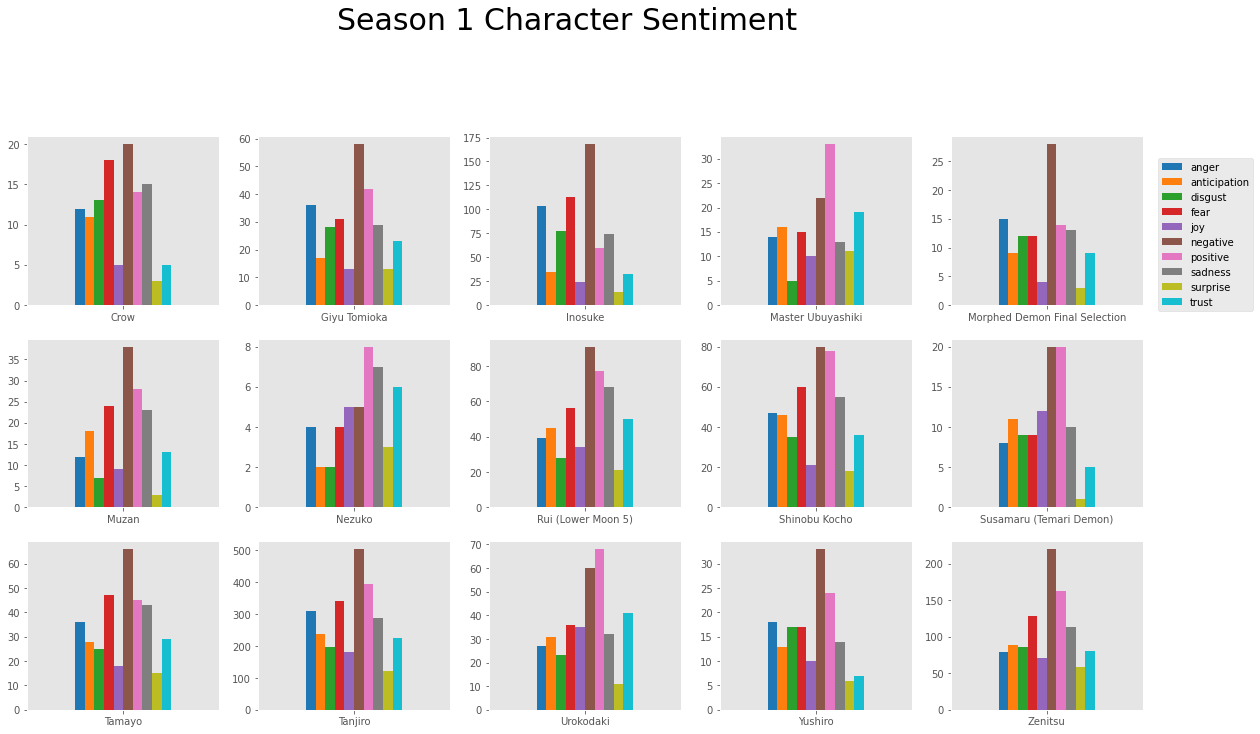

In [48]:
#But I want to check the same emotions by our "main characters"
character_sentiment = nrc_analysis[nrc_analysis['Character_name'].isin(main_characters)]
character_sentiment = character_sentiment.groupby(['Character_name','Emotion']).size().reset_index(name='Value')
character_sentiment = character_sentiment.pivot_table(columns='Emotion', values='Value', fill_value=0, index='Character_name')

main_character2 = character_sentiment.index.tolist() #I needed a fixed order, so I created a new list
labels = character_sentiment.columns.tolist()

plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Season 1 Character Sentiment", fontsize=30)

for n, char in enumerate(main_character2):
  ax = plt.subplot(5,5,n+1)
  character_sentiment[character_sentiment.index==char].plot(kind='bar',ax=ax)
  ax.set_xlabel('')
  ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
  ax.legend().remove()

plt.legend(ax, labels=labels, loc='upper right', bbox_to_anchor=(1.6,3.3))

plt.show()

In [49]:
#Finally to show a quick example of what words are responsible for generating those emotions
word_sentiment = nrc_analysis
word_sentiment = word_sentiment.groupby(['Word'])['Emotion'].value_counts().reset_index(name = 'Total')
word_sentiment = word_sentiment.sort_values(by = 'Total', ascending = False).groupby('Emotion', sort=False).head(5)
word_sentiment = word_sentiment.groupby('Emotion')['Word'].apply(list).to_frame('Examples')
word_sentiment.head(10)

,Examples
Emotion,
anger,"[demon, hell, damn, fight, attack]"
anticipation,"[time, good, wont, mountain, long]"
disgust,"[demon, hell, damn, smell, crap]"
fear,"[demon, die, hell, kill, fight]"
joy,"[good, kind, save, powerful, fun]"
negative,"[demon, die, hell, kill, damn]"
positive,"[good, master, protect, forgive, kind]"
sadness,"[demon, die, hell, kill, hurt]"
surprise,"[good, leave, lose, deal, chance]"


## 5.-Sentiment analysis with Vader

In [52]:
#Lets import vader
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

sentiment_analysis_vader = df
sentiment_analysis_vader = sentiment_analysis_vader.drop(['Dialogue_clean','NumberOfWords','Dialogue_tagged'], axis=1)
sentiment_analysis_vader["Dialog"] = sentiment_analysis_vader["Dialog"].str.replace('[^\w\s]','')

<ipython-input-52-a02e2df77ba4>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_analysis_vader["Dialog"] = sentiment_analysis_vader["Dialog"].str.replace('[^\w\s]','')


In [53]:
sentiment_analysis_vader['Score']=sentiment_analysis_vader['Dialog'].apply(lambda x: sid.polarity_scores(x))

# Place scores in own columns
sentiment_analysis_vader['CompScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("compound"))
sentiment_analysis_vader['PosScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("pos"))
sentiment_analysis_vader['NegScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("neg"))
sentiment_analysis_vader['NeuScore']=sentiment_analysis_vader.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
sentiment_analysis_vader = sentiment_analysis_vader.drop(['Score'], axis=1)

# Adding Sentiment Flags
sentiment_analysis_vader['PosFlag'] = sentiment_analysis_vader.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
sentiment_analysis_vader['NegFlag'] = sentiment_analysis_vader.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
sentiment_analysis_vader['NeuFlag'] = sentiment_analysis_vader.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

# Confirm scores are present and flag is functional
sentiment_analysis_vader.head()

,Index,Season,Episode,Episode_name,Character_name,Character_race,Gender,Dialog,Lemmatized,CompScore,PosScore,NegScore,NeuScore,PosFlag,NegFlag,NeuFlag
0,1,1,1,Cruelty,Tanjiro,Human,Male,How How did this happen Nezuko dont die Dont d...,"[happen, nezuko, die, die, going, save, matter...",0.9088,0.387,0.120,0.493,1,0,0
1,2,1,1,Cruelty,Kie Kamado,Human,Female,Tanjiro Your face is covered in soot Come over...,"[tanjiro, face, covered, soot, come, dangerous...",-0.4767,0.000,0.124,0.876,0,1,0
2,3,1,1,Cruelty,Tanjiro,Human,Male,Well I want everyone to eat their fill on New ...,"[well, want, everyone, eat, fill, new, year, g...",0.3400,0.167,0.000,0.833,1,0,0
3,4,1,1,Cruelty,Kie Kamado,Human,Female,Thank you,[thank],0.3612,0.714,0.000,0.286,1,0,0
4,5,1,1,Cruelty,Shigeru Kamado,Human,Male,Big Bro Youre going to town again today,"[big, bro, going, town, today]",0.0000,0.000,0.000,1.000,0,0,1


In [54]:
#Lets see if we can visualize the "character evolution" based on the mean score of each episode
protagonist = ['Tanjiro','Inosuke','Zenitsu','Nezuko','Urokodaki']

character_evolution_vader = sentiment_analysis_vader.groupby(['Episode','Character_name']).mean()['CompScore'].reset_index(name='sum')
character_evolution_vader = character_evolution_vader.rename(columns={'sum':'Sentiment'})
character_evolution_vader = character_evolution_vader[character_evolution_vader['Character_name'].isin(protagonist)]
character_evolution_vader['Episode'] = character_evolution_vader['Episode'].astype(int)
character_evolution_vader['Cummulative_Sentiment'] = (character_evolution_vader.groupby(['Character_name'])['Sentiment']
                                          .apply(lambda x: x.cumsum()))
character_evolution_vader = character_evolution_vader.sort_values(['Episode','Character_name'], ascending=[True,False])
#character_evolution = character_evolution.pivot_table(columns='Character_name', values='Cummulative_Sentiment', fill_value=0, index='Episode')
character_evolution_vader.head()

,Episode,Character_name,Sentiment,Cummulative_Sentiment
12,1,Tanjiro,0.129255,0.129255
3,1,Nezuko,-0.136600,-0.136600
18,2,Urokodaki,0.300789,0.300789
17,2,Tanjiro,0.012654,0.141909
16,2,Nezuko,-0.102700,-0.239300


In [55]:
sentiment_fig_vader = px.scatter(character_evolution_vader, x = 'Episode', y = 'Cummulative_Sentiment',
                           color = 'Character_name',
                           #color_discrete_sequence = legend_colors,
                           hover_data = ['Episode'],
                           trendline = 'lowess',
                           width = 750, height = 350)

# Customize titles.
sentiment_fig_vader.update_layout(title = {'text': "Sentiments per episode",
                                     'x': 0.5,
                                     'xanchor': 'center'},
                            xaxis_title = "Episode number",
                            yaxis_title = "Sentiment",
                            legend_title = "Characters")

# Correct position of x points.
for scatter, trendline in zip(sentiment_fig_vader.data[::2], sentiment_fig_vader.data[1::2]):
    trendline['x'] = scatter['x'][np.logical_not(np.isnan(scatter['y']))]
    
sentiment_fig_vader.show()

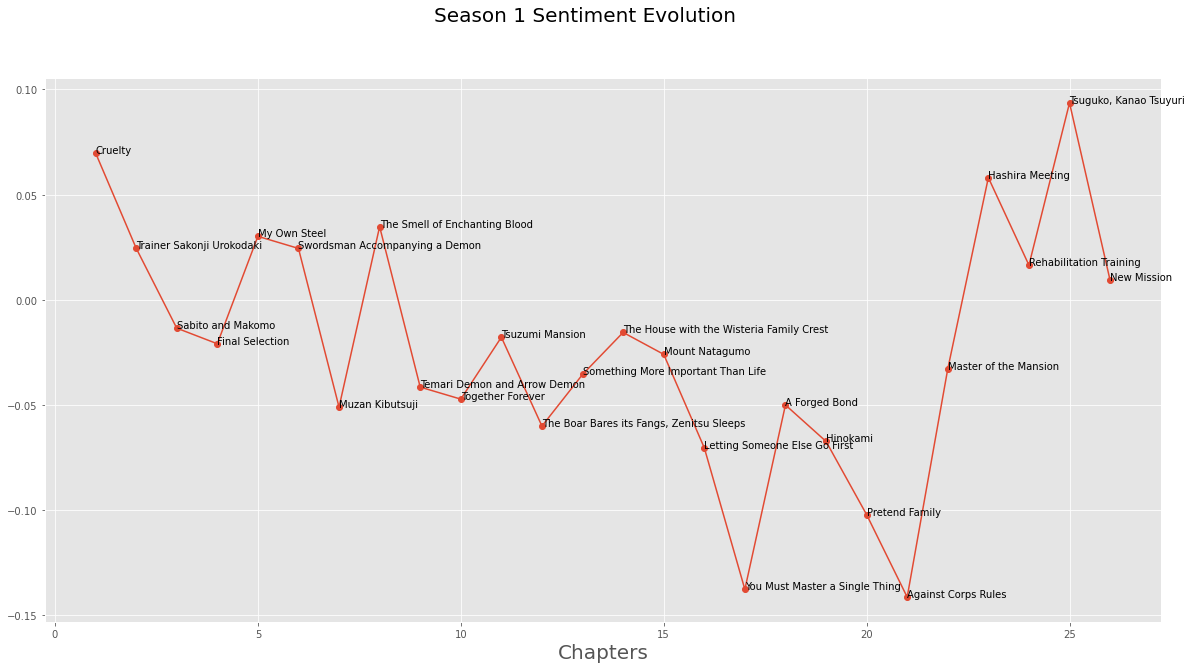

In [56]:
#What about the mean of each chapter?
chapter_evolution_vader = sentiment_analysis_vader.groupby(['Episode','Episode_name']).mean()['CompScore'].reset_index(name='sum')
chapter_evolution_vader = chapter_evolution_vader.rename(columns={'sum':'Sentiment'})
chapter_evolution_vader = chapter_evolution_vader.set_index('Episode')
chapter_evolution_vader.index.name = None

fig_vader = plt.figure(figsize=(20,10))
ax = fig_vader.suptitle('Season 1 Sentiment Evolution', size=(20))
ax = fig_vader.add_subplot(111)
plt.xlabel('Chapters', size=(20))
plt.plot(chapter_evolution_vader['Sentiment'], marker='o')

for (index, episode, sentiment) in zip(chapter_evolution_vader.index,chapter_evolution_vader['Episode_name'],chapter_evolution_vader['Sentiment']):
    ax.annotate(str(episode), xy=(index, sentiment))

plt.show()

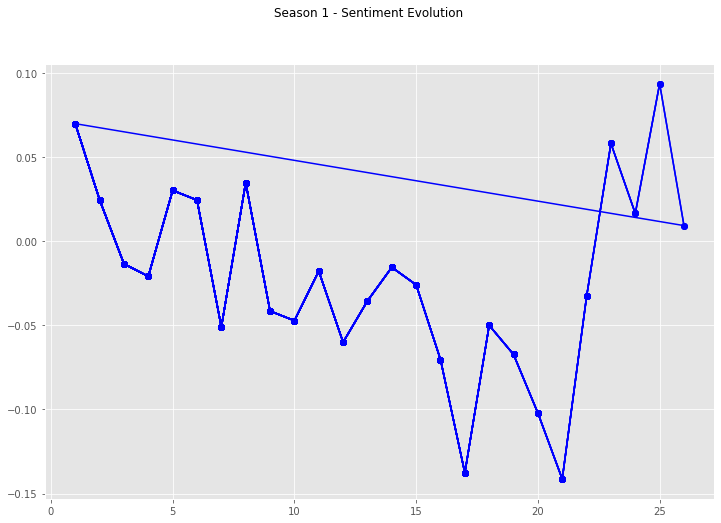

In [57]:
#And to make if fun:
animated_sentiment = chapter_evolution_vader
animated_sentiment = animated_sentiment.drop('Episode_name', axis=1)
animated_sentiment.index = animated_sentiment.index.astype('int')

x = []
y = []
y1 = animated_sentiment['Sentiment'].tolist()
t = animated_sentiment.index

fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(1,1,1)
fig.suptitle('Season 1 - Sentiment Evolution')

def animate(i):
    x.append(t[i])
    y.append((y1[i]))
    plt.plot(x,y, scaley=True, scalex=True, color="blue", marker='o')

ani = FuncAnimation(fig=fig, func=animate, interval=200, frames=26)

ani.save("Chapter sentiment evolution.mp4")

## 6.-Bechdel test

In [58]:
#Its hard to determine a way to illustrate how this scripts performs under the Bechdel test.
#My process was basically keep filtering the table until the amount of dialogues is so low that it can be checked manually.
#Its not ideal and it needs some tuning but for now its ok.
#Let start the process once again from the original data frame and lets also remember what the Bechdel test is all about:
#To pass the Bechdel test, the movie (or in this case the whole season 1) need to satisfy the following requirements:
#   *The movie has to have at least two women in it,
#   *who talk to each other,
#   *about something other than a man.

bechdel = df.drop(['Dialogue_clean','NumberOfWords','Dialogue_tagged'], axis=1)
bechdel = bechdel.groupby(bechdel['Gender'].str.startswith('Female').cumsum()).agg(' '.join) #With this I will identify which rows are interacting between 2 Female characters, discarding if the interaction is with a man.

bechdel_filter = bechdel[bechdel['Gender']=='Female']
#The folowwing filters comes from knowledge of the series, basically I am removing the characters I know for a fact that not satisfy the requirements.
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !='Gemelas']
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !='Kiyo Terauchi']
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !='Sumi Nakahara']
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !='Naho Takada']
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !="Muzan's Wife"]
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !='Mitsuri Kanroji']
bechdel_filter = bechdel_filter[bechdel_filter['Character_name'] !='Hanako Kamado']

/usr/local/lib/python3.8/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning:

Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.



In [59]:
#Lets do a quick filtering test and see if the pronouns help us determine if the conversation involves a man
bechdel_reverse = bechdel_filter[bechdel_filter['Dialog'].str.contains(" He | he | man | him | Him | his | His | he'| He'")]
x = bechdel_reverse['Dialog'].to_list()
print('\n'.join(map(str, x)))

Oh, look, there's Kazumi. Poor thing. He looks so haggard.
That man is nothing but a coward. He lives in constant fear of something.
Do you know why it is that demons can't band together? The reason why demons cannibalize each other? It's to prevent other demons from banding together and attacking him. He manipulates demons to act this way. Demons like you.
The power he wields is mind-blowing! There's no one stronger than him! Not Lord Kibutsuji!


In [60]:
#Lets apply the opposite filter
bechdel_test = bechdel_filter
bechdel_test = bechdel_test[~bechdel_test['Dialog'].str.contains(" He | he | man | him | Him | his | His | he'| He'|brother|Brother| Rui|Tanjiro")]
bechdel_test

,Episode_name,Character_name,Character_race,Gender,Dialog
Gender,,,,,
36,Swordsman Accompanying a Demon,Young Lady 3,Human,Female,It's so dreadful!
39,Swordsman Accompanying a Demon,Girl 1 Mother,Human,Female,How terrifying. I want you to stay indoors for...
54,The Smell of Enchanting Blood,Tamayo,Demon,Female,"That's right. I am... ...a demon, but I am als..."
85,The Smell of Enchanting Blood,Susamaru (Temari Demon),Demon,Female,"Vindictively, of course!"
100,Temari Demon and Arrow Demon,Susamaru (Temari Demon),Demon,Female,"Now then, let's keep playing! Until morning co..."
...,...,...,...,...,...
398,"Tsuguko, Kanao Tsuyuri",Shinobu Kocho,Human,Female,Sister!
399,"Tsuguko, Kanao Tsuyuri",Kanae Kocho,Human,Female,"You don't have to take this so seriously, you ..."
400,"Tsuguko, Kanao Tsuyuri",Shinobu Kocho,Human,Female,That's not a good reason!


In [61]:
#We can carefully analyze the remaining rows since there arent that many.
#It seems that the series barely passes, thanks to some unknown characters and the Kocho sisters
dialogues_list = bechdel_test['Dialog'].to_list()
print('\n'.join(map(str, dialogues_list)))

It's so dreadful!
How terrifying. I want you to stay indoors for the time being.
That's right. I am... ...a demon, but I am also a doctor, and I wish to annihilate that man, Kibutsuji.
Vindictively, of course!
Now then, let's keep playing! Until morning comes! Until you die!
Most likely.
You mustn't kick it!
I used a healing serum on her. Nothing more. Made exclusively for demons. It doesn't make one physically stronger. What we're seeing is Nezuko's own power. Without devouring human blood... Solely on her own... Nezuko is gaining strength at a rapid rate. However, her opponent is also formidable. If she were to go all-out, Nezuko wouldn't stand a chance. I've got to... do something.
You're an amusing little girl! This time, I'm going all-out against you! I wonder how long you can hold out!
Twelve Kizuki demon girl there.
You're in my way! Step back, you damn fugitive!
Just tell me one thing please. Are you aware of Kibutsuji's true identity?
What the hell did you say?
Stop it! Damn y

## 7.-Topic Modeling with Gensim and LDAvis

In [62]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

df_topic_m = df

# Remove punctuation
df_topic_m['Dialog_processed'] = \
df_topic_m['Dialog'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df_topic_m['Dialog_processed'] = \
df_topic_m['Dialog_processed'].map(lambda x: x.lower())

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df_topic_m.Dialog_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['happen', 'nezuko', 'die', 'die', 'gonna', 'save', 'matter', 'let', 'die', 'swear', 'big', 'brother', 'save', 'matter']


In [63]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1)]


In [70]:
#LDA Model training
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

[(0,
  '0.018*"demon" + 0.017*"right" + 0.015*"go" + 0.013*"like" + 0.010*"moons" + '
  '0.009*"even" + 0.009*"please" + 0.009*"blood" + 0.008*"hey" + 0.008*"let"'),
 (1,
  '0.011*"right" + 0.011*"nezuko" + 0.008*"like" + 0.008*"tanjiro" + '
  '0.008*"good" + 0.008*"demon" + 0.007*"ouch" + 0.007*"yeah" + 0.007*"go" + '
  '0.007*"zenitsu"'),
 (2,
  '0.017*"right" + 0.016*"yes" + 0.012*"time" + 0.012*"well" + 0.011*"going" + '
  '0.010*"thank" + 0.010*"even" + 0.010*"good" + 0.007*"take" + 0.007*"say"'),
 (3,
  '0.017*"sorry" + 0.014*"get" + 0.011*"hey" + 0.011*"crap" + 0.009*"oh" + '
  '0.008*"please" + 0.008*"one" + 0.007*"swords" + 0.007*"let" + 0.006*"come"')]


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

In [71]:
!pip install pyldavis
import pyLDAvis.gensim_models as gensimvis
import os
import pickle 
import pyLDAvis
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
